In [5]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib import colors
import glob
from land_wavelet import wclass
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from pyproj import CRS, Transformer

In [3]:
cd ..

/home/ck/pythonWorkspace


In [6]:
files = glob.glob('/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/MTG_VIS_tifs/FCI_tif_NRT/*.tif')

In [7]:
with open("/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/domain_tifs/crs_proj_geostationary_MTG.txt", "r") as f:
    crs = CRS.from_proj4(f.read())
def read_geotiff(file):
    data = rioxarray.open_rasterio(file)
    data_rio = data.rio.write_crs(crs)
    data_reprojected = data_rio.rio.reproject("EPSG:4326")

    data_reprojected = data_reprojected.sel(x=slice(13,36), y=slice(-9, -35))
    data_reprojected = data_reprojected.where(data_reprojected.values<60000, other=0)
    
    #data_reprojected = (data_reprojected - np.min(data_reprojected)) / (np.max(data_reprojected) - np.min(data_reprojected))
    #data = data.where((data>2) & (data<3))
    
    return data_reprojected.squeeze()

In [26]:
da_box = read_geotiff(files[302])

/home/ck/miniforge3/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


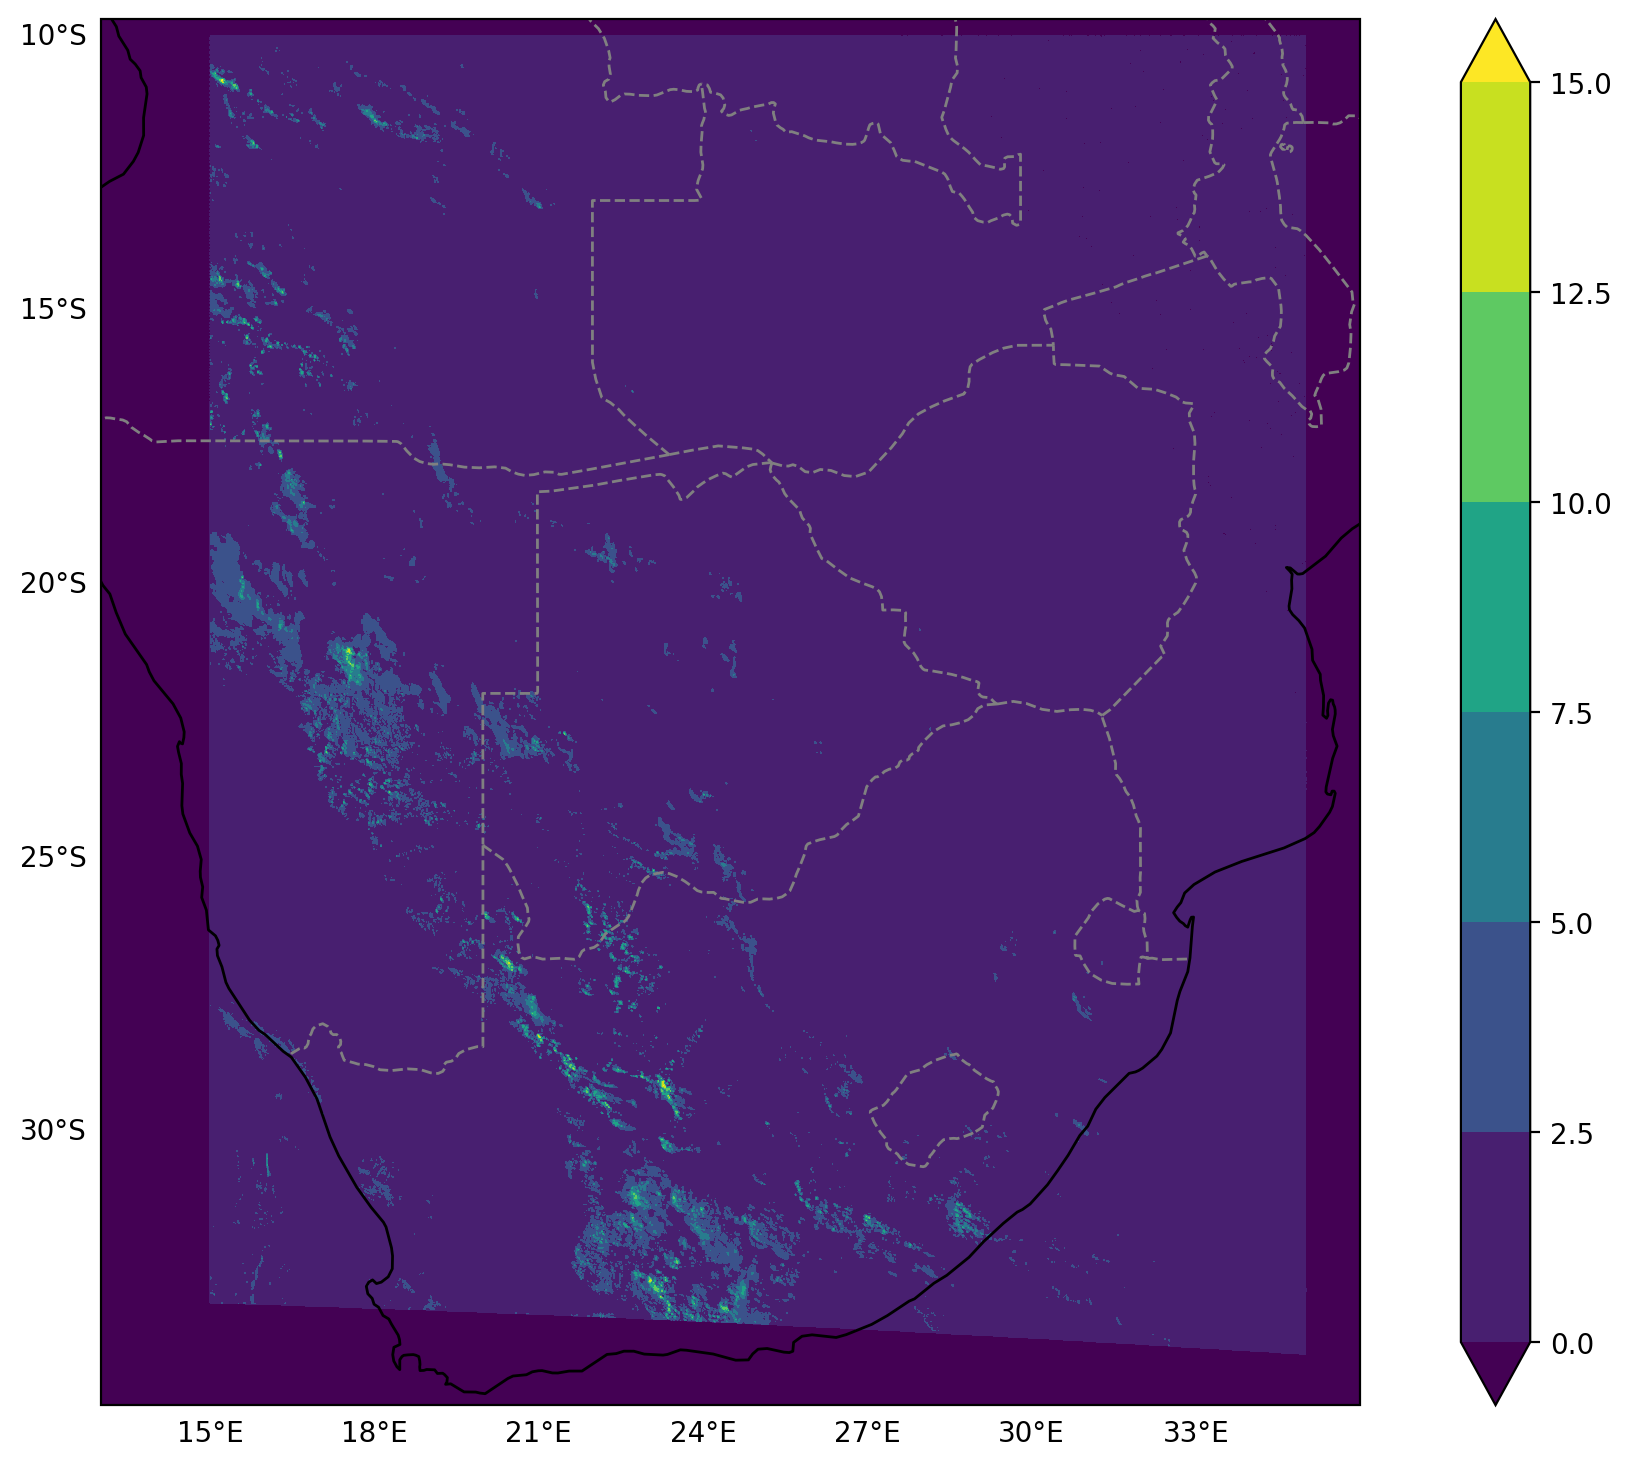

In [27]:
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
plt.contourf(da_box.x.values, da_box.y.values, da_box.where(da_box.values<60000, other=0).squeeze(), transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
ax.coastlines()

xl = ax.gridlines(draw_labels=True);
xl.top_labels = False
xl.right_labels = False
xl.xlines = False
xl.ylines=False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');

cbar = plt.colorbar()


In [28]:
da_box = da_box.sel(y=slice(-15,-33), x=slice(18,28))

In [29]:
da_box

<xarray.DataArray (y: 2580, x: 1433)> Size: 15MB
array([[1.1923994e+00, 1.1356184e+00, 1.1285208e+00, ..., 1.4196119e-02,
        1.4196119e-02, 2.1293730e-02],
       [1.1782042e+00, 1.1356184e+00, 1.1143256e+00, ..., 8.9965761e-07,
        1.4196119e-02, 8.9965761e-07],
       [1.2278874e+00, 1.1640089e+00, 1.1143256e+00, ..., 1.4196119e-02,
        1.4196119e-02, 1.4196119e-02],
       ...,
       [7.6654273e-01, 7.5944513e-01, 7.8783560e-01, ..., 1.0646424e+00,
        1.1214232e+00, 1.1853018e+00],
       [7.5944513e-01, 7.2395712e-01, 7.0976186e-01, ..., 1.0078615e+00,
        9.0139735e-01, 1.0433495e+00],
       [7.0266426e-01, 7.6654273e-01, 7.5234753e-01, ..., 1.2917659e+00,
        1.0575447e+00, 1.0078615e+00]], dtype=float32)
Coordinates:
  * x            (x) float64 11kB 18.0 18.01 18.02 18.02 ... 27.98 27.99 27.99
  * y            (y) float64 21kB -15.01 -15.01 -15.02 ... -32.99 -32.99 -33.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:        Area
    ancillary_variables:  pixel_quality
    coordinates:          y x
    description:          VIS 0.6 HR Effective radiance
    long_name:            VIS 0.6 HR Effective radiance
    unit:                 mW.m-2.sr-1.(cm-1)-1
    ...                   ...
    valid_range:          [0, 4095]
    warm_add_offset:      0
    warm_scale_factor:    0
    scale_factor:         1.0
    add_offset:           0.0
    _FillValue:           65535.0

In [30]:
### Create a wavelet decomposition object first. In this example, we initialise the SM5k 5km setup. The setups can be defined in land_wavelet.constants
wObj = wclass.landwav('VIS_05')

Initialised wavelet with scales:  [ 1.5         1.97926187  2.61165169  3.44609506  4.5471497   6.
  7.91704746 10.44660676 13.78438026 18.1885988  24.         31.66818986
 41.78642704 55.13752104 72.75439519 96.        ]


In [31]:
wObj.scales[8]

np.float64(13.784380259964422)

In [32]:
### The next step prepares the SM image for the wavelet routine. NaNs are removed by filling in zeros that can be masked again after wavelet application.
wObj.read_img(da_box.values, np.arange(0,da_box.shape[0],0.5), np.arange(0,da_box.shape[1],0.5))

In [33]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers could be used for diverse analyses.

coeffs, power, scales, period = wObj.applyWavelet(normed='stddev', ge_thresh=None, le_thresh=0, fill=0.01)

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: stddev Please note: Choose none if value reconstruction is intended.


Text(0.5, 1.0, '96.0 km scale wavelet coefficients')

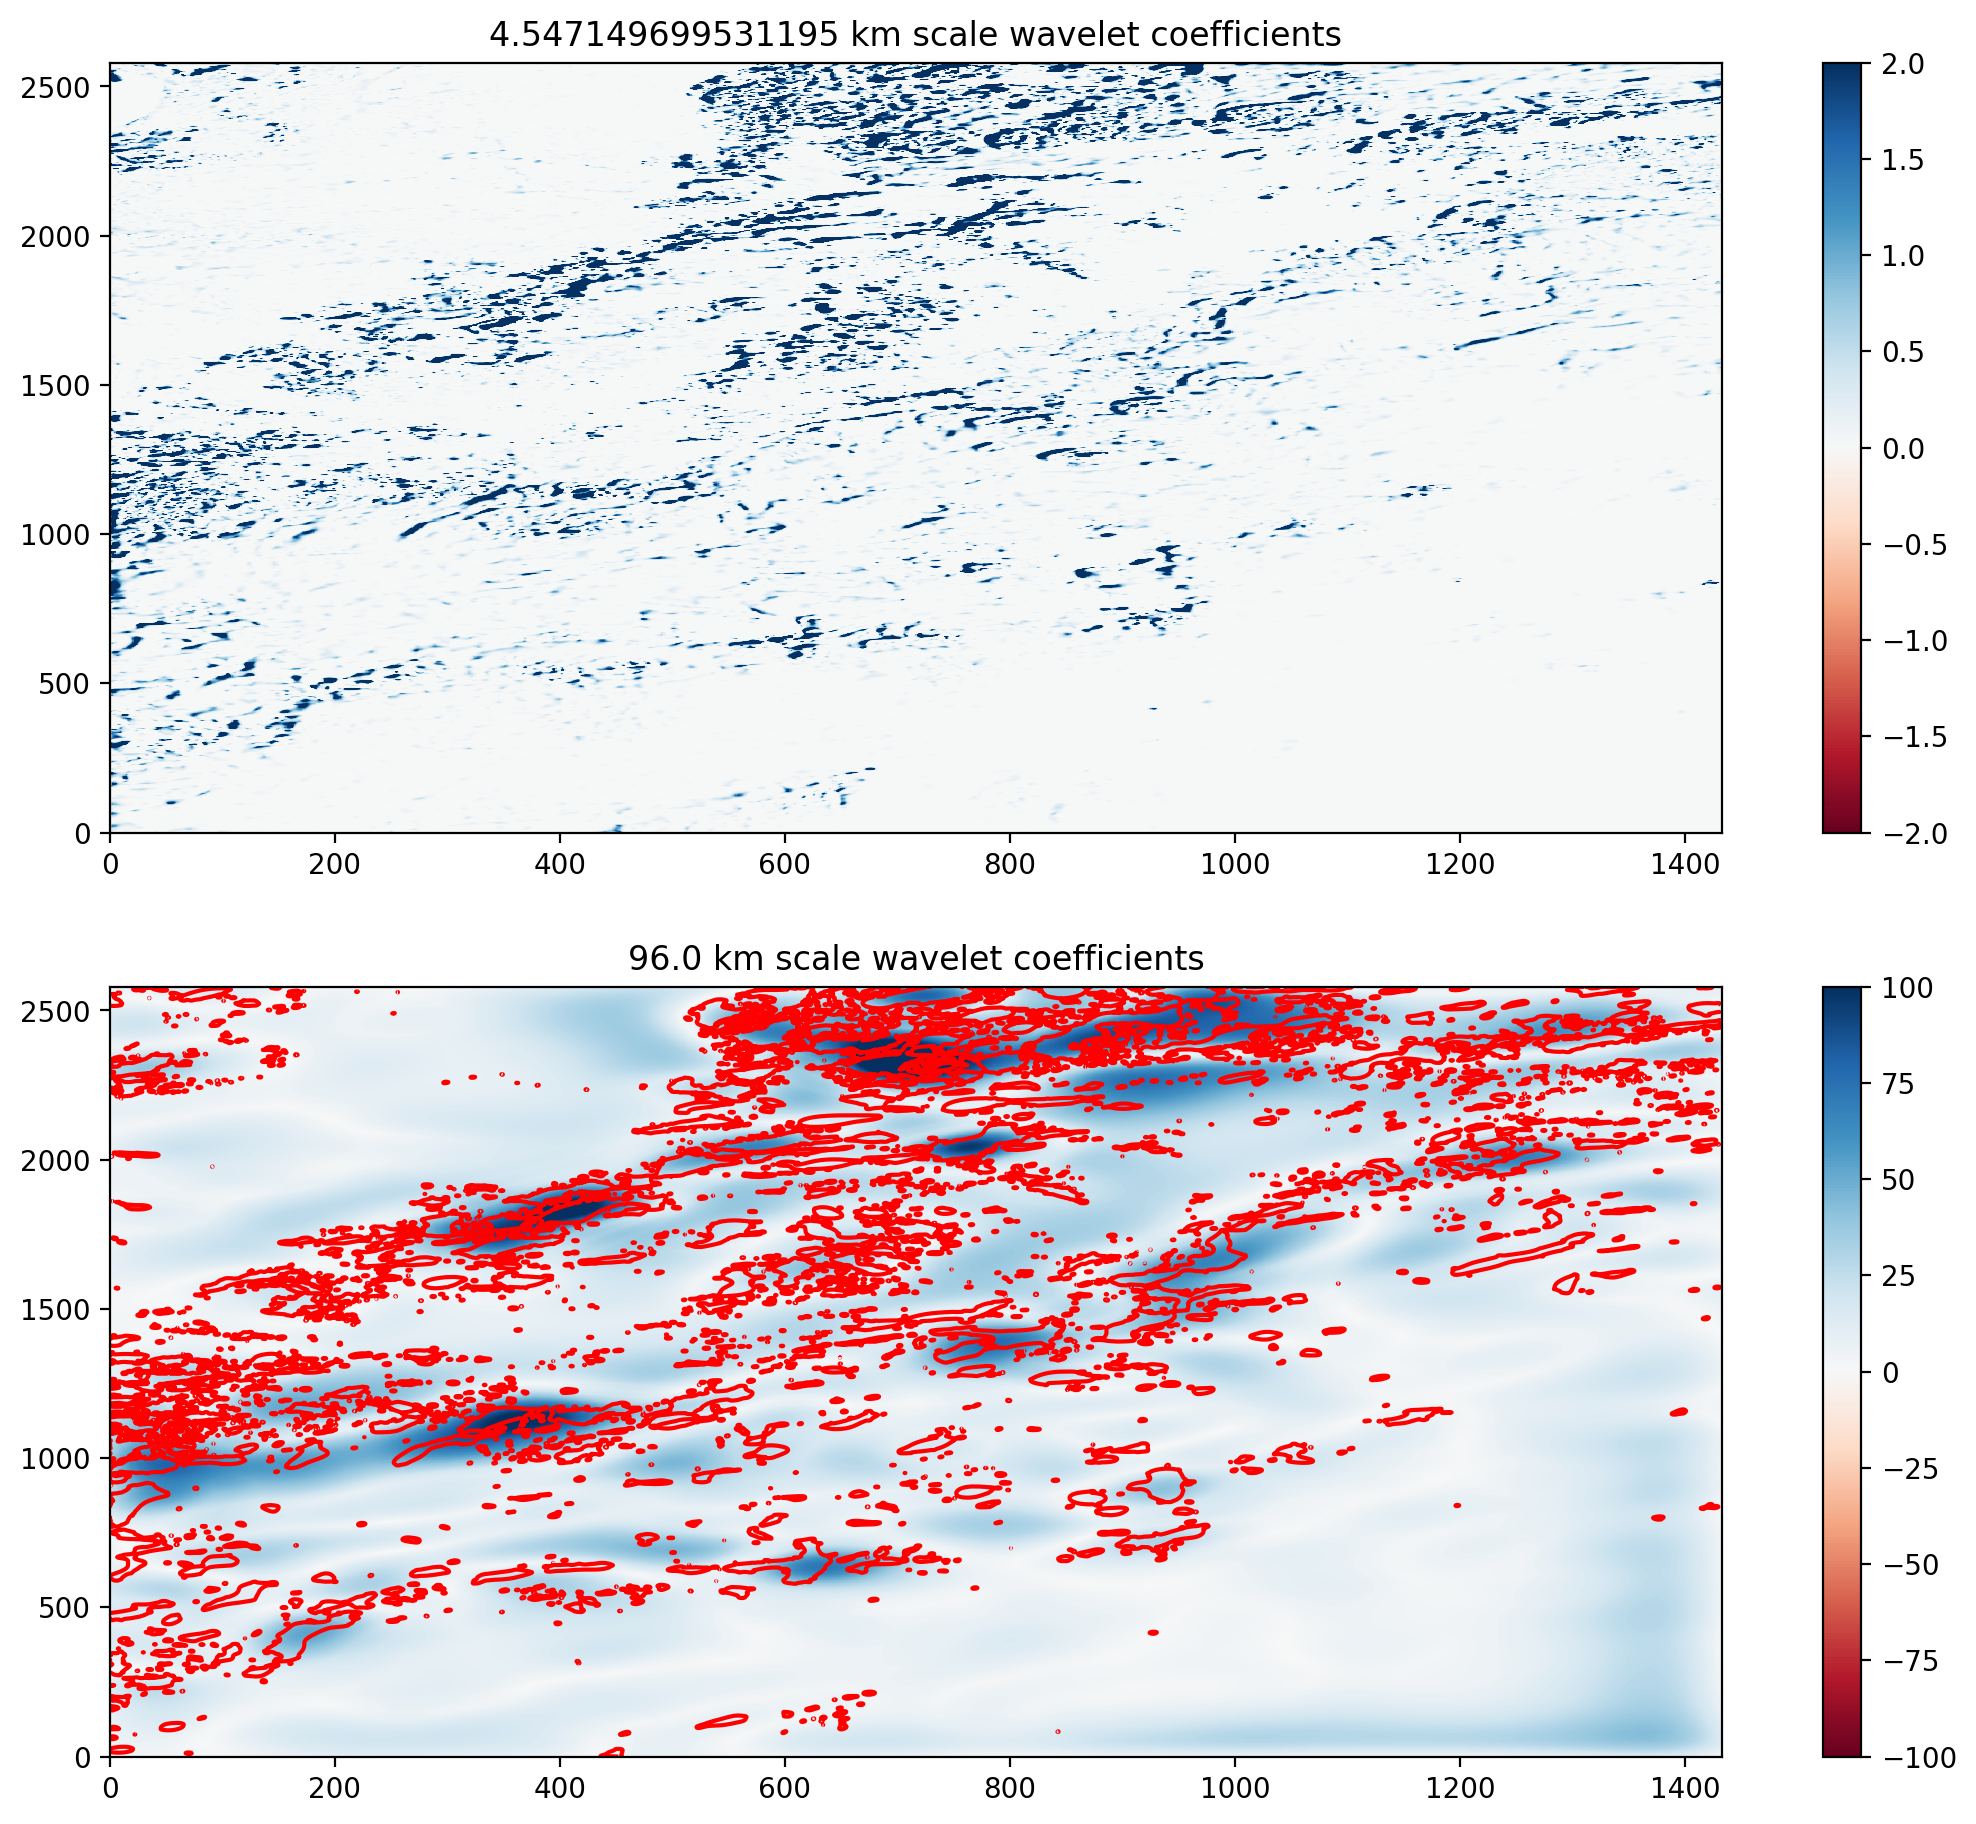

In [34]:
### This shows wavelet coefficient images of two chosen scales

f = plt.figure(figsize=(13,11), dpi=200)
ax = f.add_subplot(211)
scale_id = 4
#plt.pcolormesh(wObj.power[4,:,:], vmin=-1,vmax=1, cmap='RdBu') #np.sum(wObj.power[0:10,:,:], axis=0)
plt.pcolormesh(np.sum(wObj.power[0:6,:,:], axis=0), vmin=-2,vmax=2, cmap='RdBu') 
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')


ax = f.add_subplot(212)
scale_id = -1

plt.pcolormesh(np.sum(np.abs(wObj.coeffs[-4::,:,:]), axis=0), vmin=-100, vmax=100, cmap='RdBu')
plt.colorbar()
plt.contour(np.sum(wObj.power[0:10,:,:], axis=0), colors=['r'], levels=[0,1])

plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')

Text(0.5, 1.0, 'Contours: 2.0 km power on SM')

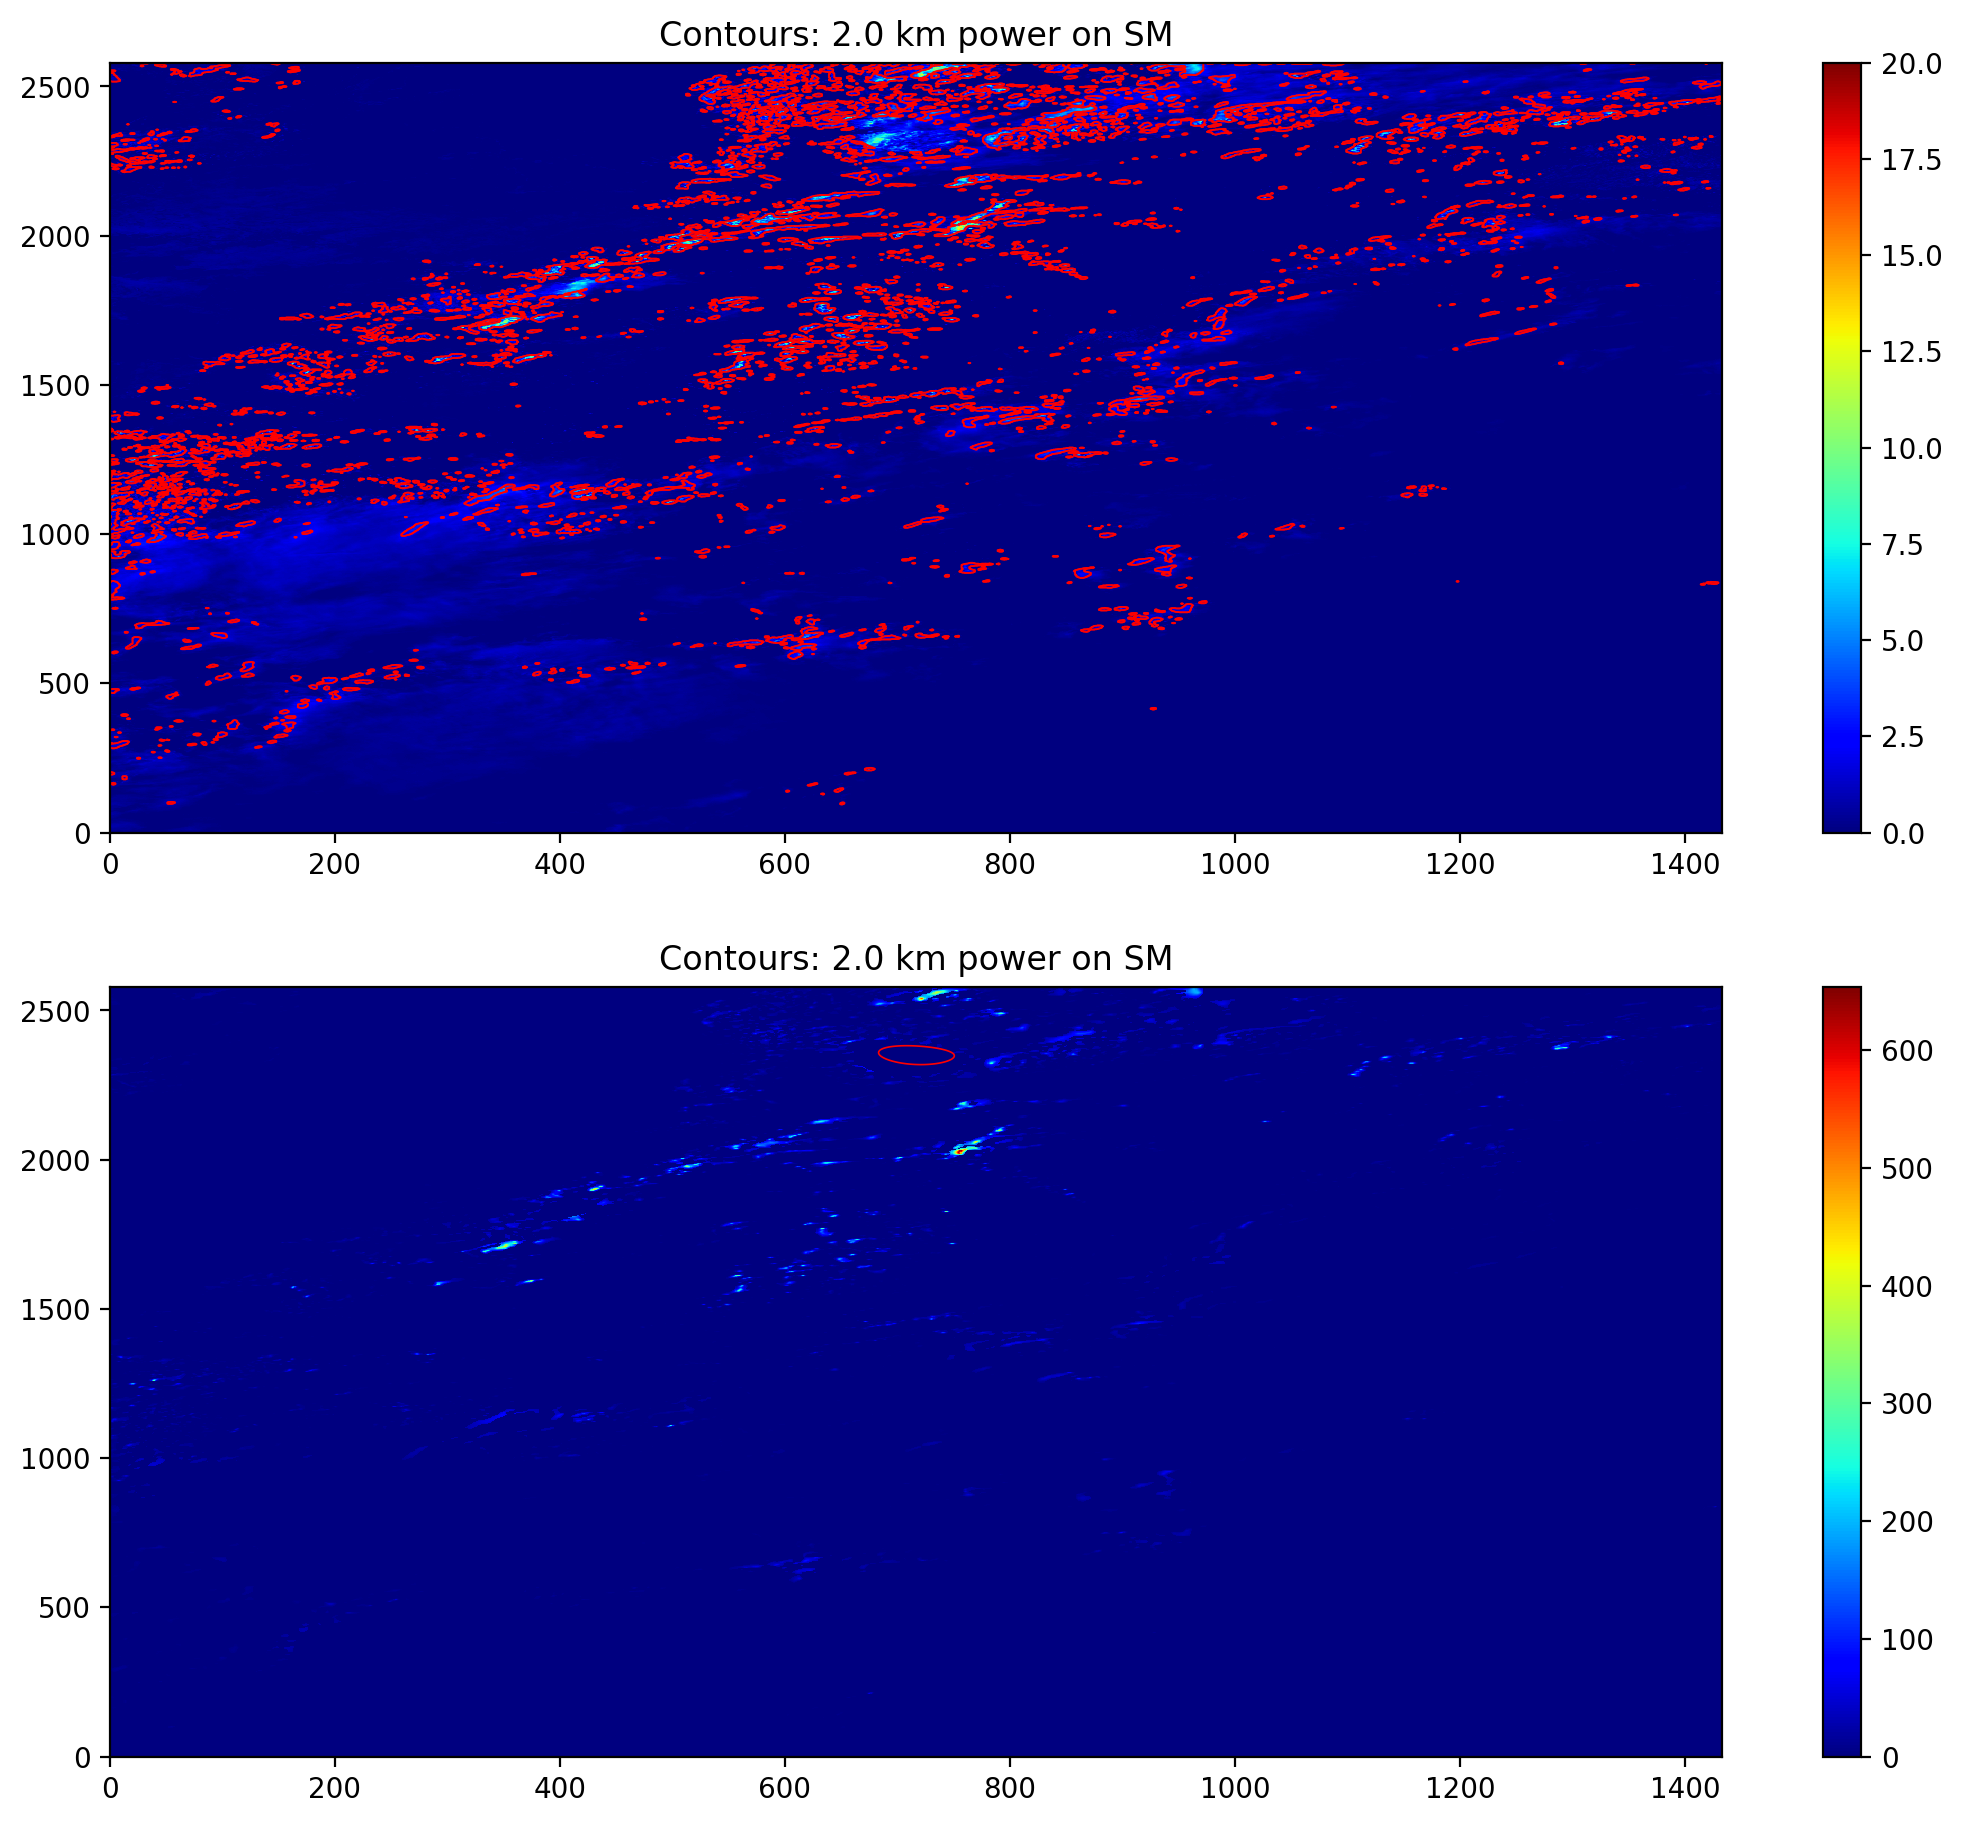

In [35]:
### Same powers as above but as contours plotted onto the SM image. 

coeffs = wObj.coeffs
coeffs_small = coeffs.copy()
coeffs_small[coeffs_small<0] = 0


f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(211)
scale_id = 2
plt.pcolormesh(wObj.image, vmax=20, vmin=0, cmap='jet')
plt.colorbar()
mask =(np.sum(wObj.coeffs[0:6,:,:], axis=0) < 0) | (np.sum(wObj.power[0:6,:,:], axis=0) < 2) | (np.sum(wObj.power[4::,:,:],axis=0)<0.25) | (np.sum(np.abs(wObj.coeffs[-4::,:,:]), axis=0) > 100)
#mask = ((np.sum(wObj.power[0:8,:,:],axis=0)<0.5) | (np.sum(wObj.power[-6::,:,:],axis=0)<0.5)) | (np.abs(wObj.coeffs[-1,:,:]) > 1)
psum = np.sum(wObj.power[:,:,:],axis=0)
psum[mask] = 0
plt.contour(psum, levels=[0,1], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')

ax = f.add_subplot(212)
scale_id = 2
plt.pcolormesh(psum, cmap='jet')
plt.colorbar()

plt.contour(wObj.power[-1,:,:], levels=[-1,10], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')

In [36]:
bools = psum

In [37]:
bools[bools>0]=1
#bools = (bools-1)*-1
bools = bools.astype(np.uint8)

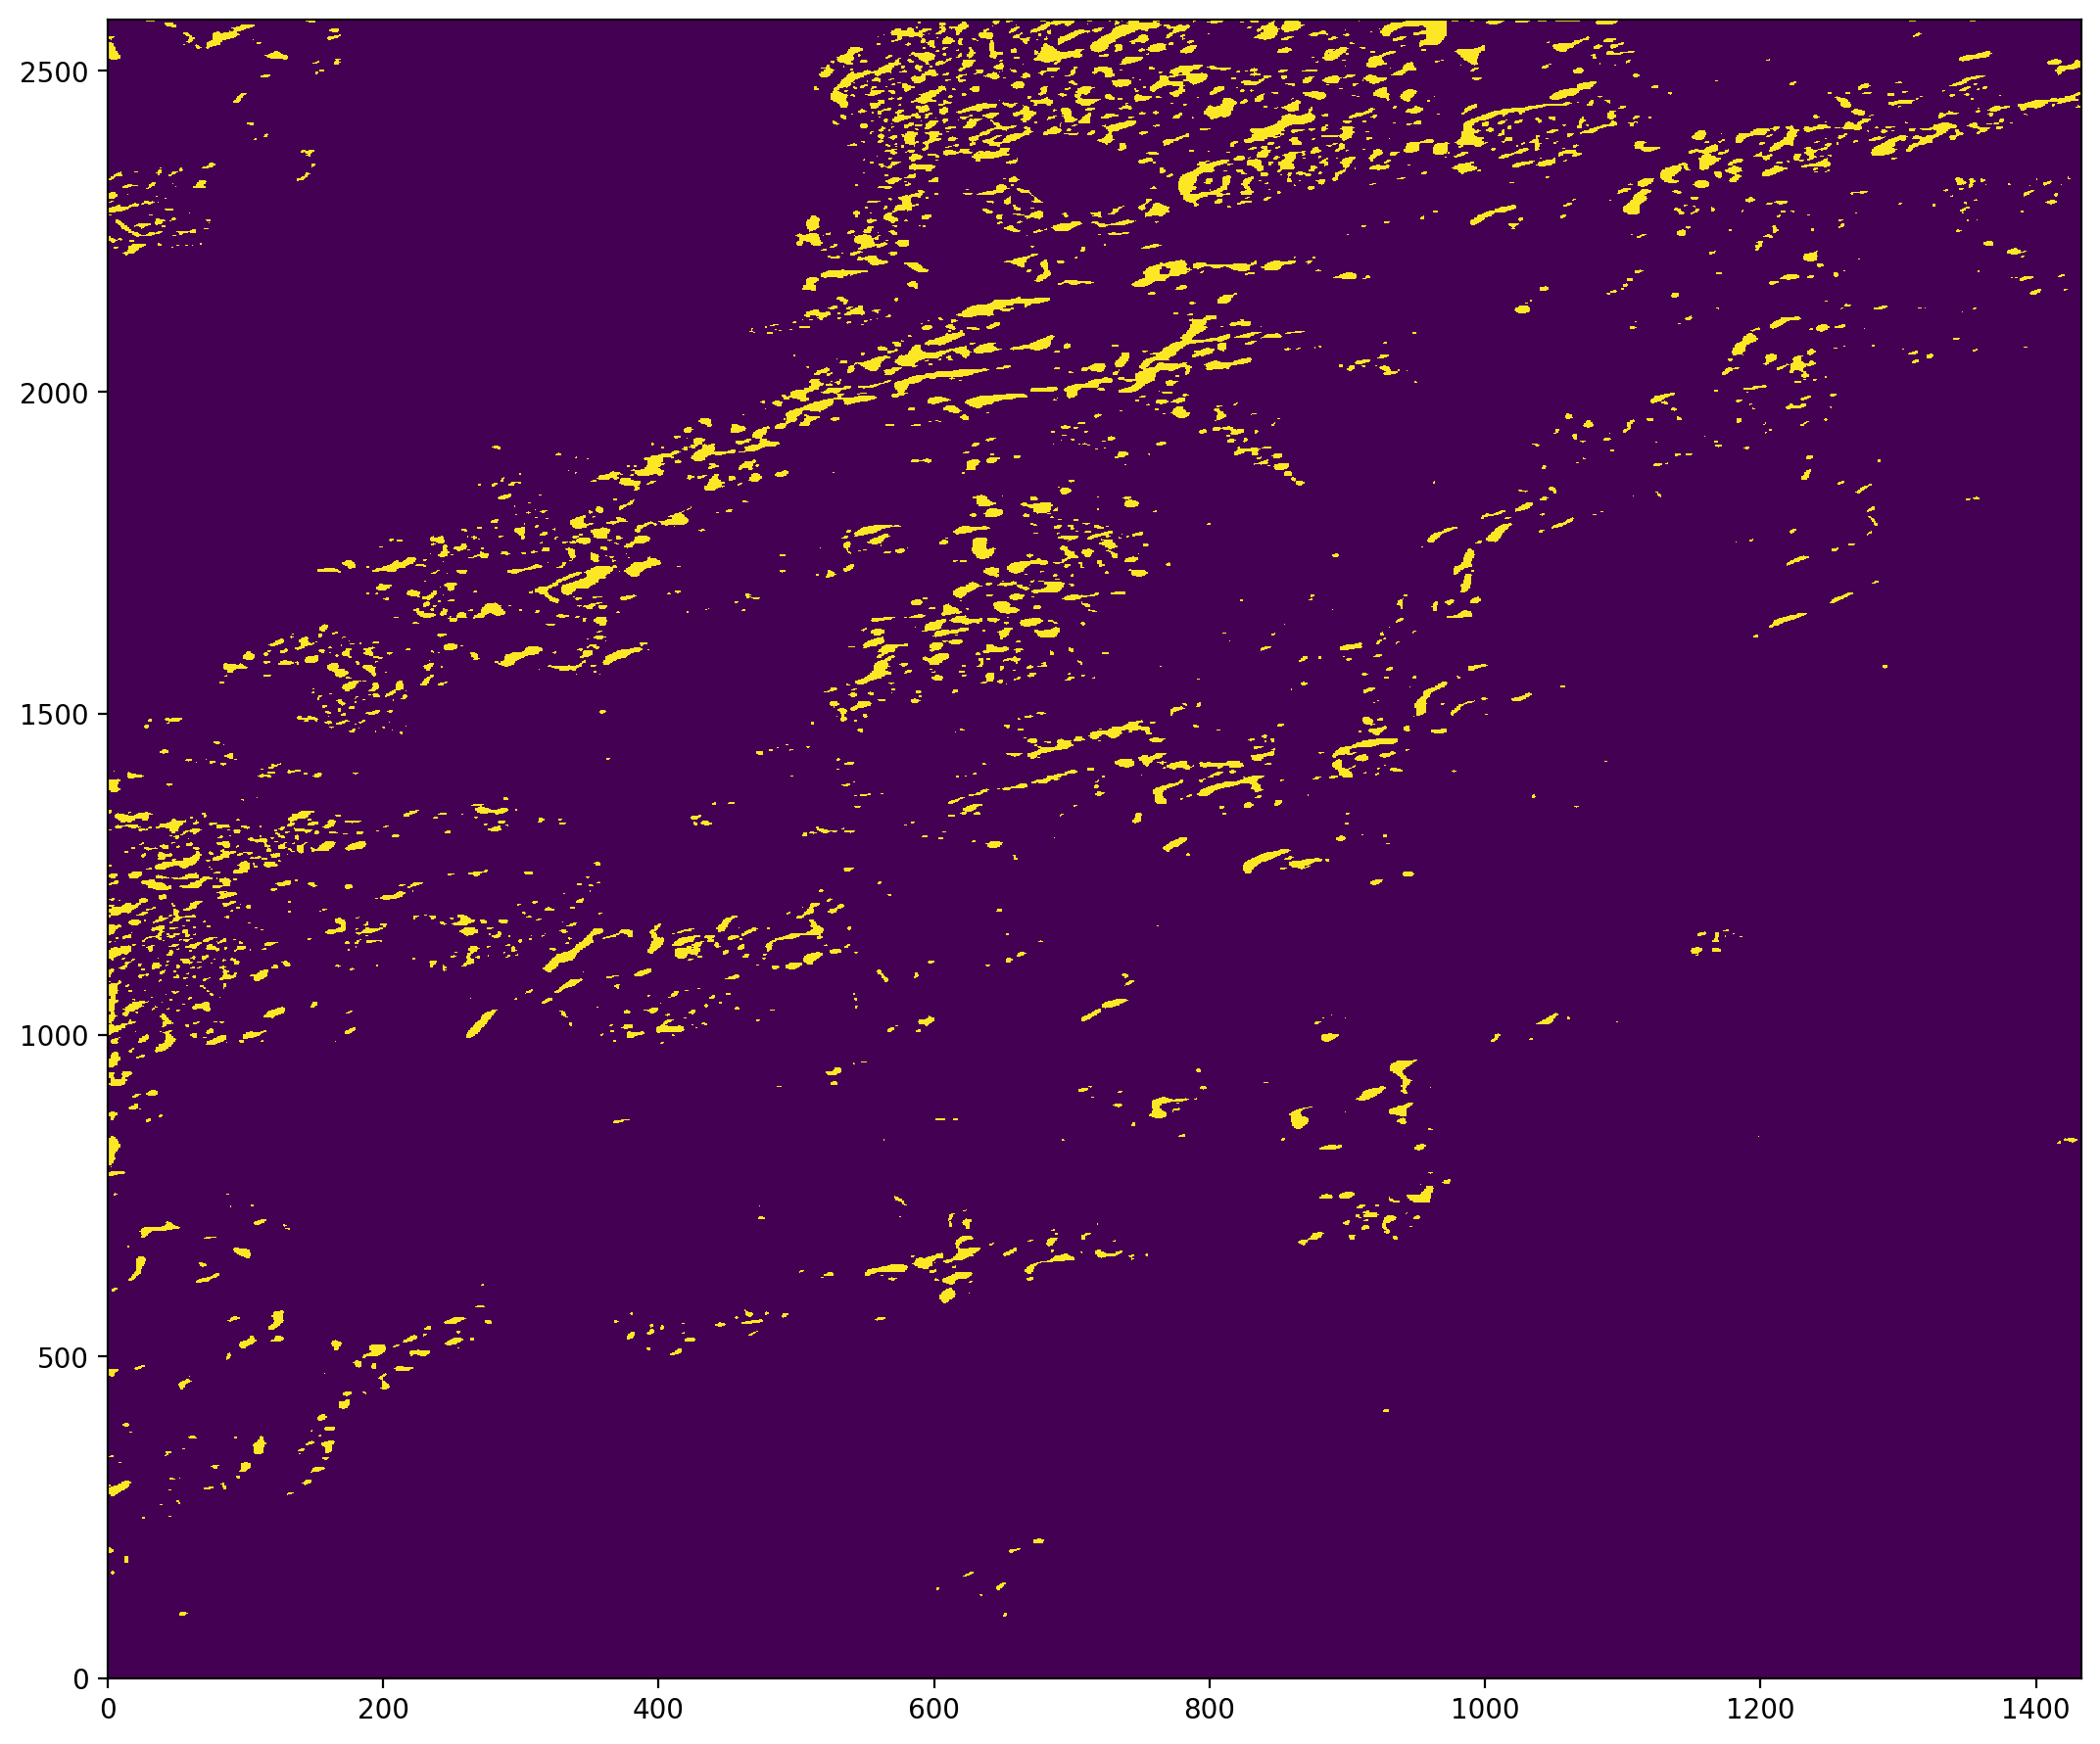

In [38]:
f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(111)
plt.pcolormesh(bools)

In [39]:
from land_wavelet import line_detection

In [40]:
merged_lines = line_detection.run_line(bools, threshold=5, minLineLength=50, maxLineGap=8)

In [41]:
merged_lines.shape

(32, 4)

In [42]:
#circles = line_detection.run_circle(bools, min_radius=5, max_radius=0)

42 1030 43 979
319 1098 357 1165
324 1673 355 1728
333 1754 371 1805
372 1863 432 1927
502 1948 538 2005
545 2204 553 2269
557 1553 565 1606
572 2046 626 2100
579 2474 604 2392
748 2004 800 2119
749 2519 783 2570
750 2454 781 2507
781 2305 796 2358
813 1923 868 1858
833 2348 865 2449
940 960 942 908
979 2386 1012 2437
551 626 606 659
36 1157 93 1132
17 1252 75 1284
669 1432 747 1487
520 2001 627 2074
699 2007 760 2026
779 2078 831 2088
617 2121 679 2146
598 2369 652 2372
816 2388 884 2412
571 2427 642 2442
790 2508 853 2487
620 2541 622 2564
734 2567 785 2569


(2000.0, 2500.0)

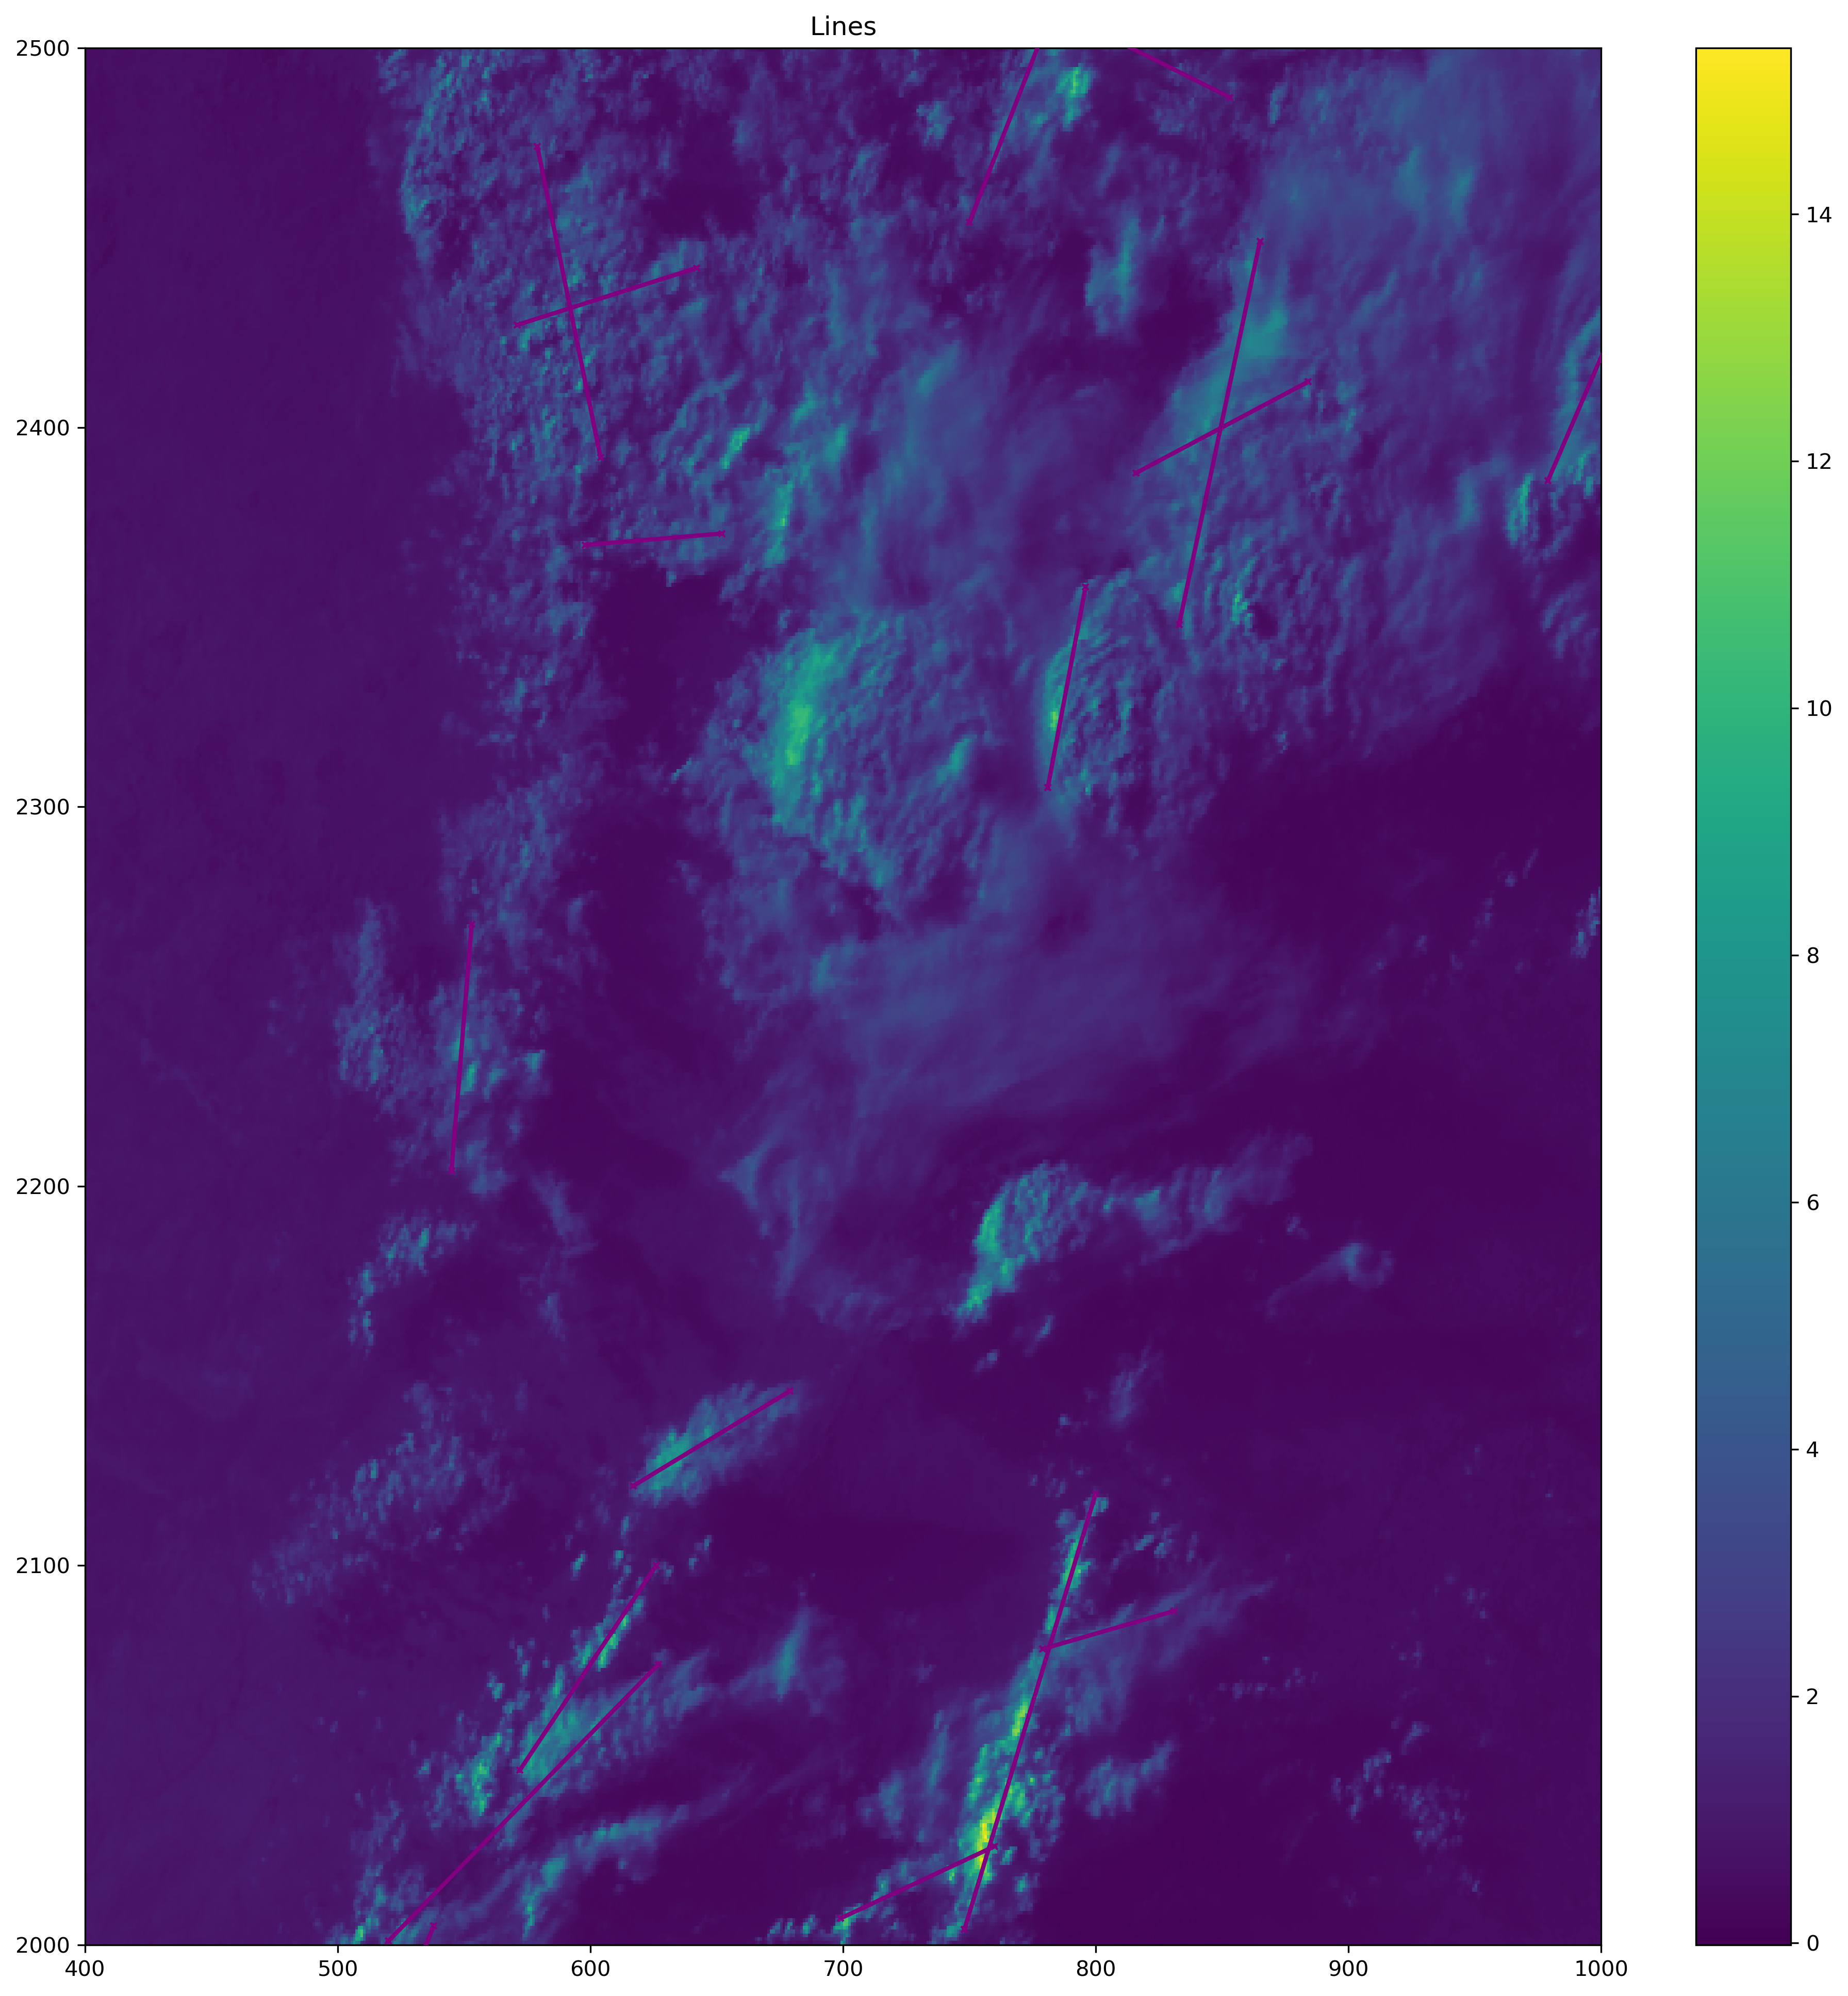

In [43]:
f = plt.figure(figsize=(13,13), dpi=300)

# ax = f.add_subplot(221)

# mp=ax.pcolormesh(bools, cmap='jet')
# plt.colorbar(mp)
# plt.title('Bools')


ax = f.add_subplot(111)

mp= ax.pcolormesh(da_box, cmap='viridis', zorder=0)
plt.colorbar(mp)
plt.title('Lines')

#for line in merged_lines:
for x1, y1, x2, y2 in merged_lines:
    print(x1, y1, x2, y2)
    
    ax.plot([x1, x2], [y1, y2], marker = 'x', markersize=3, color='purple', linestyle='solid', linewidth=2, zorder=99)
plt.tight_layout()
#f.savefig('/home/ck/Desktop/test2.png')
ax.set_xlim(400,1000)
ax.set_ylim(2000,2500)